# Credit Card Fraud Detection
### Presented by Ratnam!

Throughout the financial sector, machine learning algorithms are being developed to detect fraudulent transactions.  In this project, that is exactly what we are going to be doing as well.  Using a dataset of of nearly 28,500 credit card transactions and multiple unsupervised anomaly detection algorithms, we are going to identify transactions with a high probability of being credit card fraud.  In this project, we will build and deploy the following two machine learning algorithms:

* Isolation Forest Algorithm

Furthermore, using metrics suchs as precision, recall, and F1-scores, we will investigate why the classification accuracy for these algorithms can be misleading.

In addition, we will explore the use of data visualization techniques common in data science, such as parameter histograms and correlation matrices, to gain a better understanding of the underlying distribution of data in our data set. Let's get started!

## 1. Importing Necessary Libraries

To start, let's print out the version numbers of all the libraries we will be using in this project. This serves two purposes - it ensures we have installed the libraries correctly and ensures that this tutorial will be reproducible. 

In [2]:
import sys
import numpy
import pandas
import matplotlib
import seaborn
import scipy

print('Python: {}'.format(sys.version))
print('Numpy: {}'.format(numpy.__version__))
print('Pandas: {}'.format(pandas.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Seaborn: {}'.format(seaborn.__version__))
print('Scipy: {}'.format(scipy.__version__))


Python: 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
Numpy: 1.16.2
Pandas: 0.24.2
Matplotlib: 3.0.3
Seaborn: 0.9.0
Scipy: 1.2.1


In [3]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 2. The Data Set

In the following cells, we will import our dataset from a .csv file as a Pandas DataFrame.  Furthermore, we will begin exploring the dataset to gain an understanding of the type, quantity, and distribution of data in our dataset.  For this purpose, we will use Pandas' built-in describe feature, as well as parameter histograms and a correlation matrix. 

In [4]:
# Load the dataset from the csv file using pandas
data = pd.read_csv('E:\\GIt\\Fraud Detection\\Credit-card-Fraud-detection\\creditcard.csv')

In [5]:
# Start exploring the dataset
print(data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [6]:
# Print the shape of the data
data = data.sample(frac=0.30, random_state = 100)
print(data.shape)
print(data.describe())

# V1 - V28 are the results of a PCA Dimensionality reduction to protect user identities and sensitive features

(85442, 31)
                Time            V1            V2            V3            V4  \
count   85442.000000  85442.000000  85442.000000  85442.000000  85442.000000   
mean    94766.810363     -0.004230      0.012809     -0.007017     -0.000682   
std     47545.998690      1.961454      1.637528      1.523148      1.413266   
min         1.000000    -56.407510    -72.715728    -48.325589     -5.683171   
25%     54016.000000     -0.928139     -0.594004     -0.890770     -0.847024   
50%     84844.500000      0.016832      0.071365      0.175781     -0.014756   
75%    139315.500000      1.315636      0.811443      1.020285      0.741952   
max    172785.000000      2.439207     22.057729      4.226108     16.491217   

                 V5            V6            V7            V8            V9  \
count  85442.000000  85442.000000  85442.000000  85442.000000  85442.000000   
mean       0.000918     -0.002704     -0.001496     -0.001481      0.003257   
std        1.416269      1.344

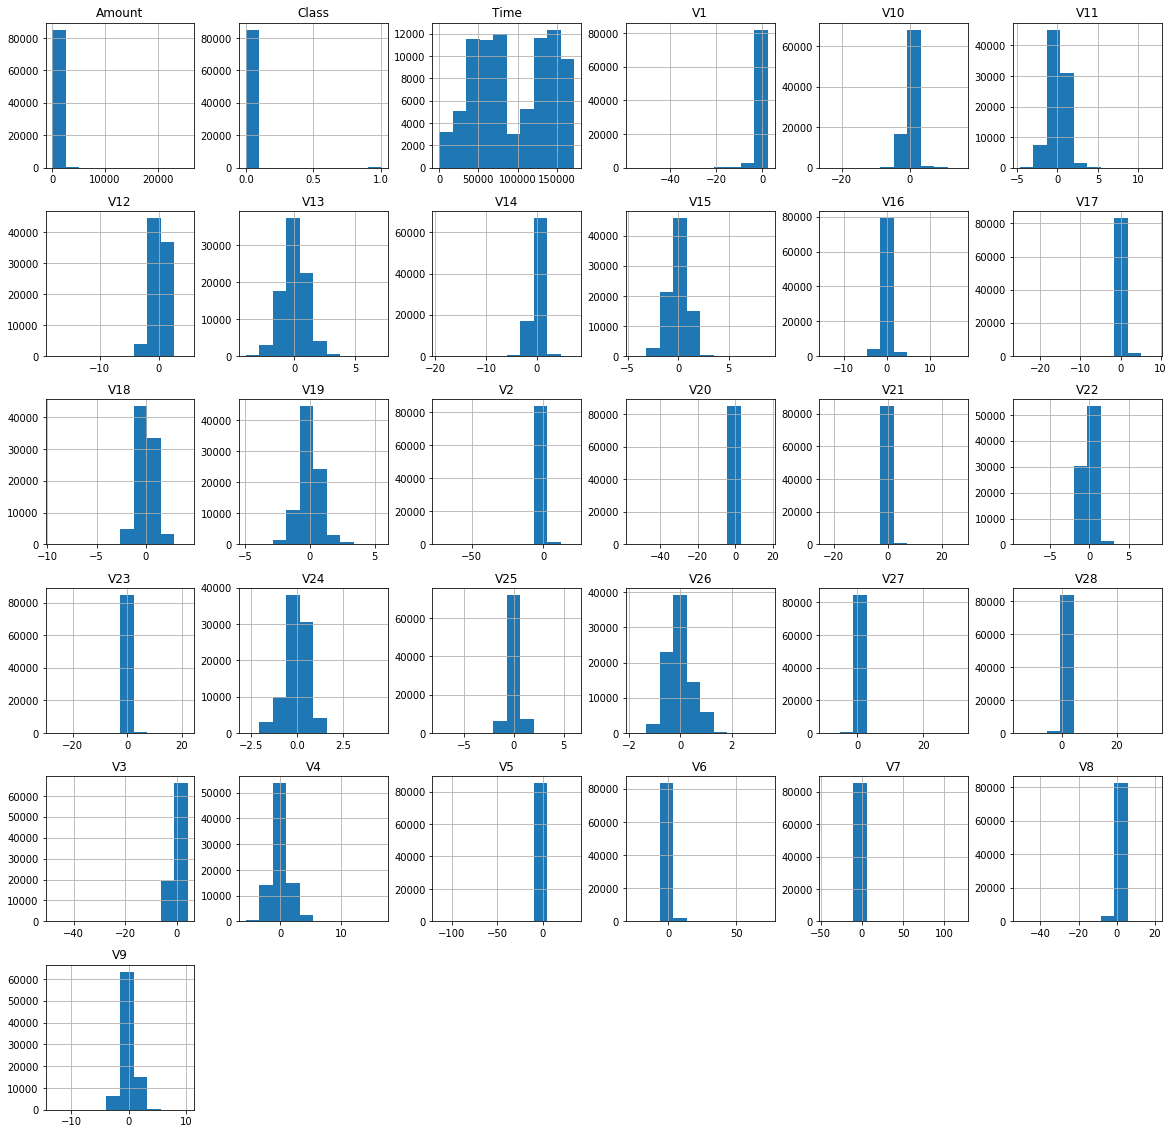

In [7]:
# Plot histograms of each parameter 
data.hist(figsize = (20, 20))
plt.show()

In [8]:
# Determine number of fraud cases in dataset

Fraud = data[data['Class'] == 1]
Valid = data[data['Class'] == 0]

outlier_fraction = len(Fraud)/float(len(Valid))
print(outlier_fraction)

print('Fraud Cases: {}'.format(len(data[data['Class'] == 1])))
print('Valid Transactions: {}'.format(len(data[data['Class'] == 0])))



0.0016647127784290739
Fraud Cases: 142
Valid Transactions: 85300


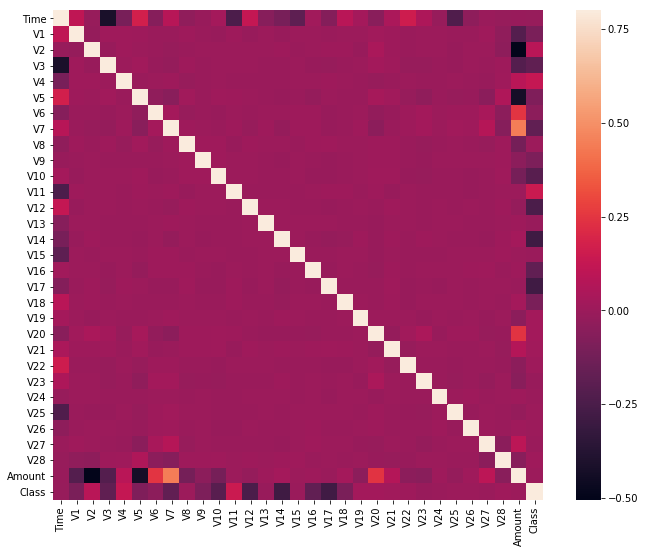

In [9]:
# Correlation matrix
corrmat = data.corr()
fig = plt.figure(figsize = (12, 9))

sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

In [10]:
# Get all the columns from the dataFrame
columns = data.columns.tolist()

# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["Class"]]

# Store the variable we'll be predicting on
target = "Class"

X = data[columns]
Y = data[target]

# Print shapes
print(X.shape)
print(Y.shape)

(85442, 30)
(85442,)


## 3. Unsupervised Outlier Detection

Now that we have processed our data, we can begin deploying our machine learning algorithms.  We will use the following techniques: 

**Isolation Forest Algorithm**

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting 
a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to 
isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees 
collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

In [11]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest

# define random states
state = 1

# define outlier detection tools to be compared
classifiers = {
    "Isolation Forest": IsolationForest(max_samples=len(X),
                                        contamination=outlier_fraction,
                                        random_state=state)}

In [12]:
# Fit the model
plt.figure(figsize=(9, 7))
n_outliers = len(Fraud)


for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    clf.fit(X)
    scores_pred = clf.decision_function(X)
    y_pred = clf.predict(X)
    
    # Reshape the prediction values to 0 for valid, 1 for fraud. 
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    n_errors = (y_pred != Y).sum()
    
    # Run classification metrics
    print('{}: {}'.format(clf_name, n_errors))
    print(accuracy_score(Y, y_pred))
    print(classification_report(Y, y_pred))


C:\Users\ratna\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\ratna\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Isolation Forest: 201
0.9976475269773648
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85300
           1       0.29      0.30      0.29       142

   micro avg       1.00      1.00      1.00     85442
   macro avg       0.65      0.65      0.65     85442
weighted avg       1.00      1.00      1.00     85442



<Figure size 648x504 with 0 Axes>